<h3 align="center">
  <a href="https://arxiv.org/pdf/2507.05120" target="_blank">
    Experimental Data Re-Uploading with Provable Enhanced Learning Capabilities<br>
    <em>Pérez-Salinas et al. (2025)</em>
  </a>
</h3>

This notebook reproduces the key experimental results from the aforementionned paper
using <a href="https://github.com/merlinquantum/merlin">Merlin</a> and <a href="https://perceval.quandela.net/">Perceval</a>. 
<br>
The main goal is to demonstrate how data reuploading can be used to enhance learning capabilities.
<br>
In particular, we will see that increasing the number of data reuploading module in the quantum circuit leads increases the accuracy of a binary classifier.
<br>
To do so, the focus is made in the reproduction of Figure 5 from the paper:

<p align="center">
  <img src="https://arxiv.org/html/2507.05120v1/x3.png" alt="Ansatz Extension" style="width: 50%; height: auto;">
</p>

<br>

**Code Location:**  
This jupyternotebook is designed to efficiently showcase experiments.
Most of the code is imported from python files.
The most important one is the `reuploading_experiment.py`, which contains:
- `ReUploadCircuitModelTwoMode`: The LO circuit model which composes the first layer of our model.
- `fisher_logratio_loss`: The loss function used for obtaining suitable parameters for the LO circuit during the training phase. 
- `DeepLDAClassifier1D`: The classical LDA which composes the second layer of our model.

as well as,

- `MerlinReuploadingClassifier`: Merlin integration using autogradient from PyTorch
- `PercevalReuploadingClassifier`: Perceval integration using COBYLA or PSR optimization and suited for remote jobs on QPU.

<br>

---

## Datasets

The datasets specified in the paper are :

### Circle Dataset

> *The circles dataset feature bi-dimensional data. The former is created using the implementation of the Python library scikit-learn. <br> Hereby the scaling factor between the inner and outer circles is 0.6 with 0.05 Gaussian noise.*


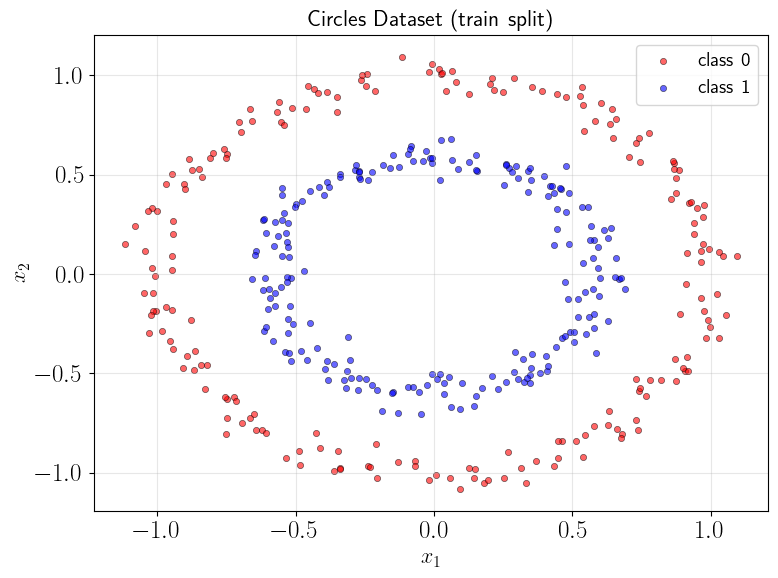

In [1]:
from paper_datasets import CirclesDataset

circles_dataset = CirclesDataset(n_train=400, n_test=100)
circles_dataset.plot_samples()


### Moons Dataset

> *"The second dataset, instead, features two interleaving half circles... again the implementation from scikit-learn was used, with 0.1 Gaussian noise."*


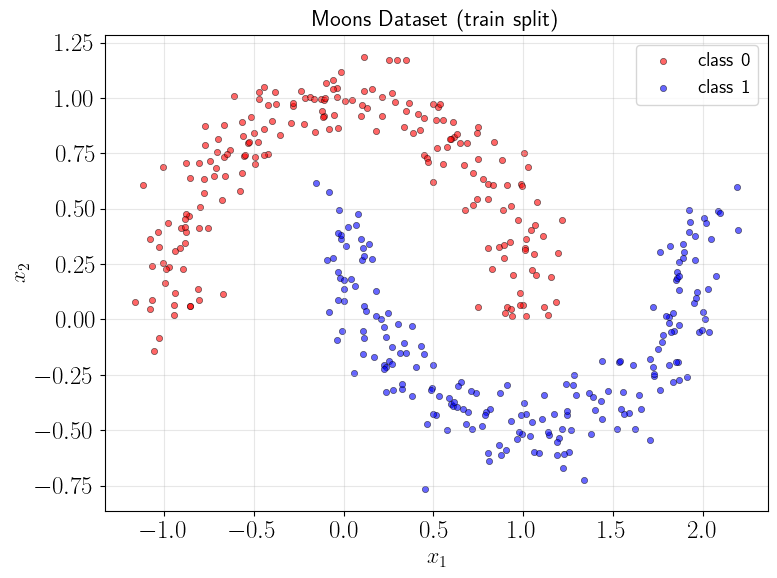

In [2]:
from paper_datasets import MoonsDataset

moons_dataset = MoonsDataset(n_train=400, n_test=100)
moons_dataset.plot_samples()

### Tetromino Dataset

>*The tetromino dataset, instead, features 3 × 3 pixel figures, representing “T” and “L” letters, corresponding to classes 1 and 2, as in Fig. 5c. 
<br>
These letters are represented by black and white pixels. 
 Then, to make the task more complex, we add uniform background noise bounded between *−0.1* and *0.1* to these 3 by 3 matrices and we add to the dataset also the negative of the images.*

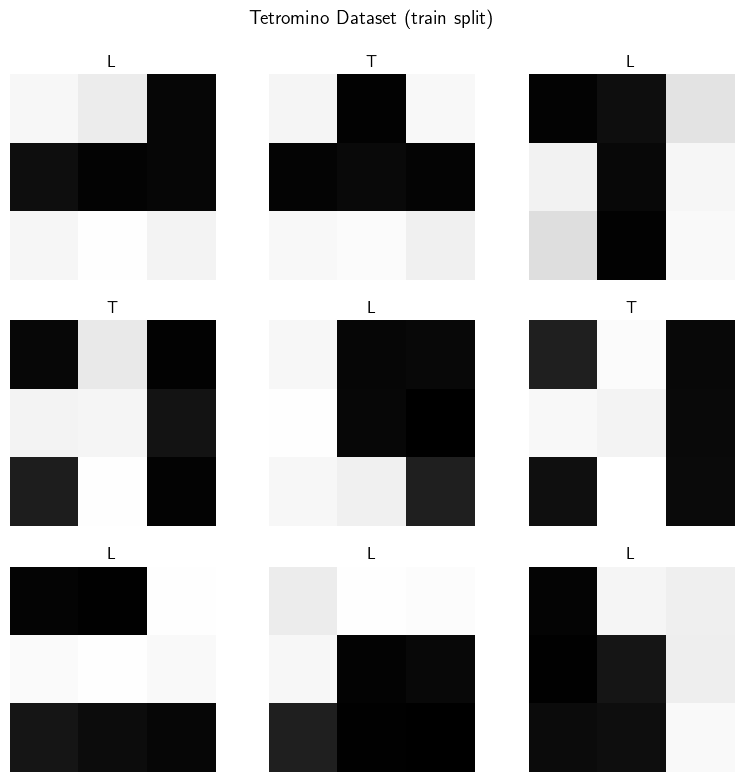

In [3]:
from paper_datasets import TetrominoDataset

tetromino_dataset = TetrominoDataset(n_train=400, n_test=100)
tetromino_dataset.plot_samples()

### OverheadMNIST  Dataset
This dataset has been downloaded from kaggle:
`! kaggle datasets download datamunge/overheadmnist -p overheadmnist`

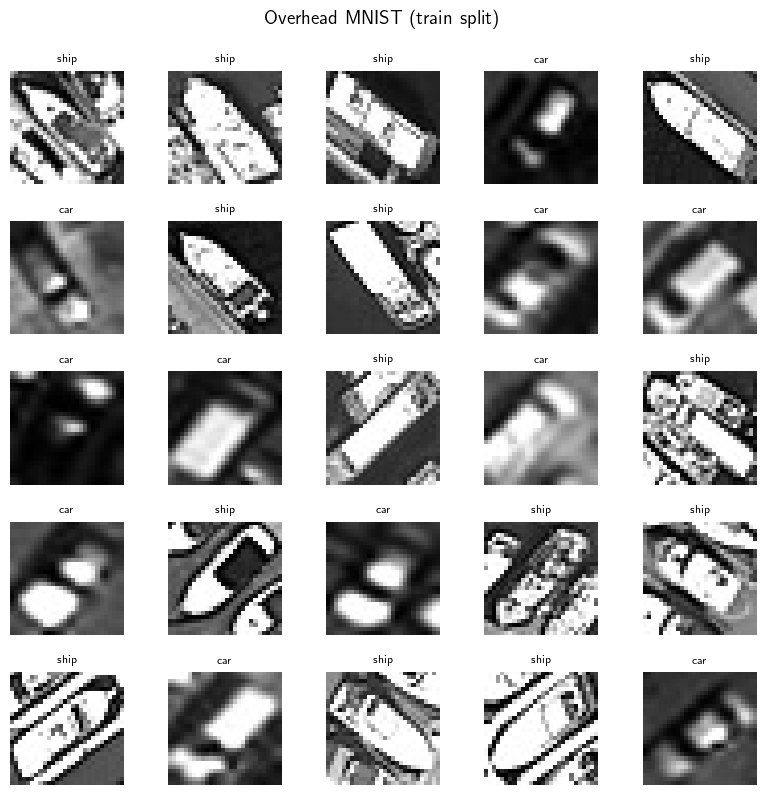

In [4]:
from paper_datasets import OverheadMNISTDataset

overhead_dataset = OverheadMNISTDataset(root="overheadmnist")
overhead_dataset.plot_samples()

## Classifier

### Circuit Architecture - Two mode with data reuploading

This circuit is used to obtain "good" `quantum_features` from the original set of data `x`. By "good" it is understood, sufficiently separable.
<br>
The circuit is decomposed in modules combining *data encoding* and *trainable* submodules consisting ine one tunable ${PS}(\phi_1)$ and $BS(\phi_2)$. This circuit architecture is called here "AA". But many other have been implemented.
<br>
For more details, have a look at the [original paper](https://arxiv.org/pdf/2507.05120).

In [5]:
import perceval as pcvl
# Perceval parameters
phi1 = pcvl.Parameter("phi1")
phi2 = pcvl.Parameter("phi2")

print("Parametrized BS")
pcvl.pdisplay(pcvl.BS(phi1).U)

print("Simplification in ILO components")
c = pcvl.Circuit(2)
c.add(0,pcvl.BS()) 
c.add(0,pcvl.PS(phi1/2)) 
c.add(1,pcvl.PS(-phi1/2)) 
c.add(0,pcvl.BS())
pcvl.pdisplay(c.U)

Parametrized BS


<IPython.core.display.Math object>

Simplification in ILO components


<IPython.core.display.Math object>

In [6]:
def circuit_A():
    """A: PS0(phi1) ▸ BS ▸ PS0(phi2) ▸ BS"""
    c = pcvl.Circuit(2)
    c.add(0, pcvl.PS(phi1), merge=True)
    c.add(0, pcvl.BS(),     merge=True)
    c.add(0, pcvl.PS(phi2), merge=True)
    c.add(0, pcvl.BS(),     merge=True)
    return c

def circuit_B():
    """B: PS0(phi1) ▸ BS0(phi2)"""
    c = pcvl.Circuit(2)
    c.add(0, pcvl.PS(phi1), merge=True)
    c.add(0, pcvl.BS(phi2), merge=True)
    return c

def circuit_C():
    """C: PS0(phi1) ▸ PS1(phi2) ▸ BS"""
    c = pcvl.Circuit(2)
    c.add(0, pcvl.PS(phi1), merge=True)
    c.add(1, pcvl.PS(phi2), merge=True)
    c.add(0, pcvl.BS(),     merge=True)
    return c

def symbolic_U(builder):
    """Return the PARAMETRIC unitary U(phi1, phi2)."""
    return builder().U

def numeric_U(builder, v1, v2):
    """Return numeric unitary for concrete (phi1, phi2) values."""
    return builder().compute_unitary(assign={phi1: v1, phi2: v2})


for name, build in [("A", circuit_A), ("B", circuit_B), ("C", circuit_C)]:
    print(f"\nCircuit circuit_{name}:")
    pcvl.pdisplay(build().U)


Circuit circuit_A:


<IPython.core.display.Math object>


Circuit circuit_B:


<IPython.core.display.Math object>


Circuit circuit_C:


<IPython.core.display.Math object>

In [7]:
import perceval as pcvl
from reuploading_experiment import ReUploadCircuitModelTwoMode

dimension = len(["x_1", "x_2"])
num_layers = 1

circuit_model = ReUploadCircuitModelTwoMode(dimension, num_layers, design="AA") # By default, design is "AA" and corresponds to the one from the original paper
pcvl.pdisplay(circuit_model.circuit)
pcvl.pdisplay(circuit_model.circuit.U)

# circuit_model = ReUploadCircuitModelTwoMode(dimension, num_layers, design="BB")
# pcvl.pdisplay(circuit_model.circuit)
# pcvl.pdisplay(circuit_model.circuit.U)

<IPython.core.display.Math object>

Note: In the paper the classical data are mapped to the tunable phases through the transformation
\begin{equation}
    x \to \phi=x\cdot\pi/2
\end{equation}

In this code this map is specified by an hyperparameter `alpha`,
\begin{equation}
    x \to \phi=x\cdot\texttt{alpha}
\end{equation}
`alpha` = $\pi/4$ by default.

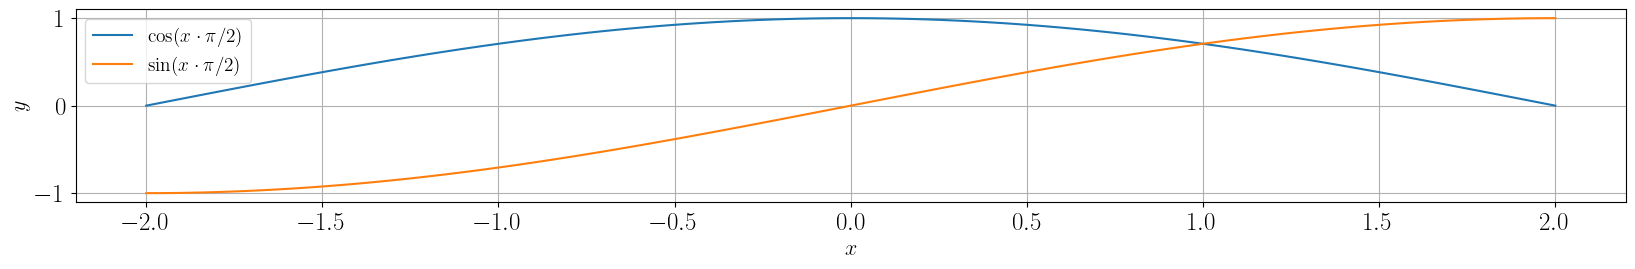

In [4]:
import numpy as np
import matplotlib.pyplot as plt

alpha = np.pi/4
x = np.linspace(-2, 2, 100)
cos = np.cos((x * alpha))
sin = np.sin((x * alpha))

plt.figure(figsize=(20, 2.5))
plt.plot(x, cos, label=r"$\cos(x\cdot\pi/2)$")
plt.plot(x, sin, label=r"$\sin(x\cdot\pi/2)$")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True)
plt.legend()
plt.show()

### Decision Output — LDA classifier in the learned feature space

After training the quantum layer, the classification of the quantum features is performed using an LDA classifier.
See Dorfer *et al.*: [Deep Linear Discriminant Analysis](https://arxiv.org/abs/1511.04707).

In the general (HDim) case, let $h$ denote the topmost hidden representation, $A$ the LDA projection matrix, and $\bar H_c$ the per‑class mean features. 
<br>
DeepLDA forms linear decision scores via distances to decision hyperplanes:
\begin{equation}
d(h) \;=\; h^\top T^\top \;-\; \tfrac{1}{2}\,\mathrm{diag}\!\big(\bar H_c\,T^\top\big),
\qquad
T \;=\; \bar H_c\,A A^\top .
\end{equation}
We predict the class with the largest score:
$
\hat{y} \;=\; \arg\max_c d_c(h).
$
<br>
In our implementation the feature space is 1D because $p_{01}+p_{10}=1$, where $p_{01}$ ($p_{10}$) corresponds to the probability of measuring a photon in the bottom (top) mode. 
<br>
We take $p \;:=\; p_{10}\in[0,1]$, and the rule above specializes to a very simple closed form. Let $m_c$ be the mean of $x$ for class $c$. The per‑class score becomes
\begin{equation*}
\boxed{\; d_c(p) \;=\; m_c\,p \;-\; \tfrac{1}{2}\,m_c^{2} \;}
\end{equation*}
and the prediction is $\hat y=\arg\max_c d_c(p)$.
For binary classes $c\in\{0,1\}$, this yields a single threshold at the midpoint of the class means:
\begin{equation*}
p^\star \;=\; \tfrac{1}{2}\big(m_0 + m_1\big), \quad
\text{predict } 1 \text{ iff } p > p^\star \quad\text{(without loss of generality)}.
\end{equation*}

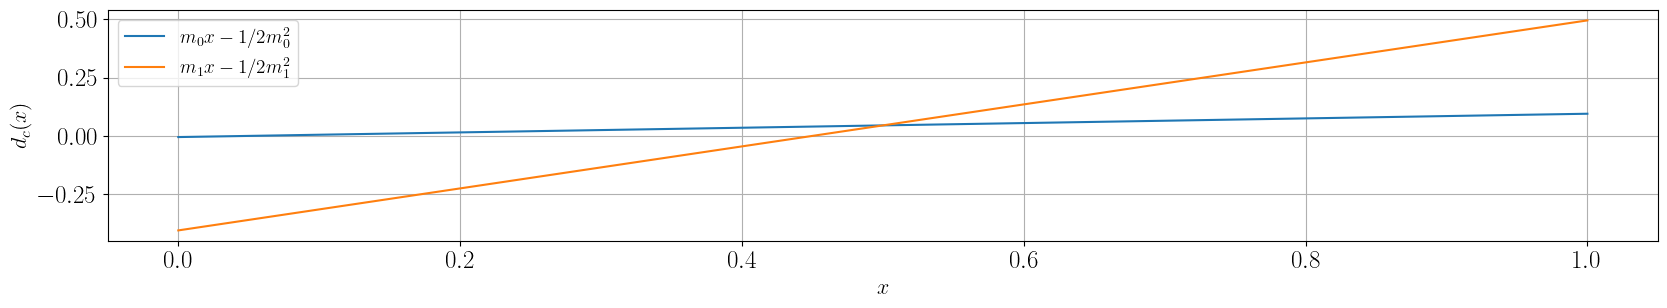

In [5]:
m_0, m_1 = 0.1, 0.9
x = np.linspace(0, 1, 100)

plt.figure(figsize=(20, 3))
plt.plot(x, m_0*x-1/2*m_0**2, label=r'$m_0 x -1/2 m_0^2$')
plt.plot(x, m_1*x-1/2*m_1**2, label=r'$m_1 x -1/2 m_1^2$')
plt.xlabel('$x$')
plt.ylabel('$d_c(x)$')
plt.grid(True)
plt.legend()
plt.show()

### Loss Function - Balance between within class and accross class variance

The training is only performed on the circuit parameters in order for the 1D quantum feature, $p$, to become linearly separable.  

On a batch $\{(x_i, y_i)\}_{i=1}^N$ with classes $c=1,\ldots,C$, let $\mu_c$ be the class‑mean of the features and $\mu$ the global mean.
<br>
The within‑class and between‑class variance are,

\begin{equation*}
S_w \;=\; \frac{1}{C-1}\sum_{c=1}^{C}\ \sum_{i:\,y_i=c} \big(x_i - \mu_c\big)^2,
\end{equation*}

\begin{equation*}
S_b \;=\; \frac{1}{N-1}\sum_{c=1}^{C} n_c\,\big(\mu_c - \mu\big)^2,
\end{equation*}

where $n_c$ is the number of samples of class $c$ in the batch.  
In 1D the LDA generalized eigenvalue simply becomes
\begin{equation*}
\lambda_\star \;=\; \frac{S_b}{S_w + \varepsilon}.
\end{equation*}
Rather than maximizing $\lambda_\star$ explicitly, as it is described in [Deep Linear Discriminant Analysis](https://arxiv.org/abs/1511.04707), the objective is the minimization of the log‑ratio Fisher loss (DeepLDA‑inspired, eigenvalue‑free, batch‑friendly):

\begin{equation*}
\boxed{\quad
\mathcal{L}_{\text{Fisher}}(\tau)
\;=\;
-\Big[\,\log\!\big(S_b+\varepsilon\big)\;-\;\tau\,\log\!\big(S_w+\varepsilon\big)\,\Big]
\quad}
\end{equation*}

with a small $\varepsilon>0$ for numerical stability and a trade‑off $\tau$:
- $\tau > 1$: stresses compactness.
- $\tau < 1$: stresses separation.

 Circuit Parameters Optimization: 
- `MerlinReuploadingClassifier`: Single optimization approach 
    - Gradients are computed via torch automatic differentiation and the ADAM optimizer is used.
- `PercevalReuploadingClassifier`: Two optimization approach are provided
    - Gradient-free optimization using the COBYLA optimizer.
    - Gradients are computed using the parameter‑shift rule (PSR) and the ADAM optimizer is used.

In [10]:
from paper_datasets import CirclesDataset
circles_dataset = CirclesDataset(n_train=400, n_test=100)

from paper_datasets import MoonsDataset
moons_dataset = MoonsDataset(n_train=400, n_test=100)

### Merlin Training - Example

     Train: 1.0
     Test : 1.0


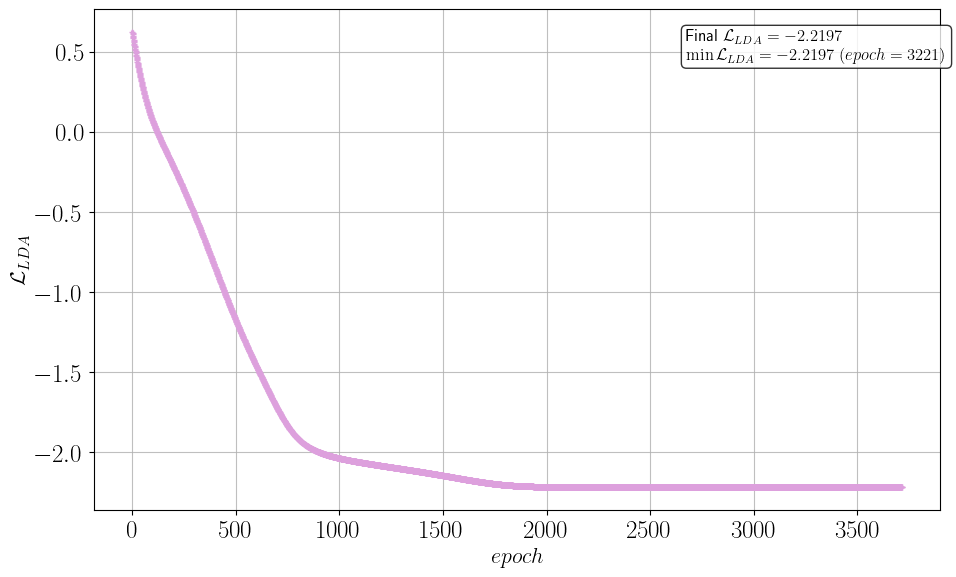

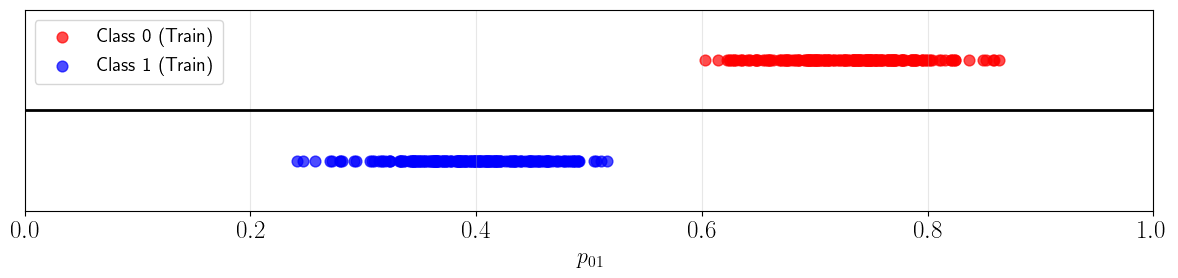

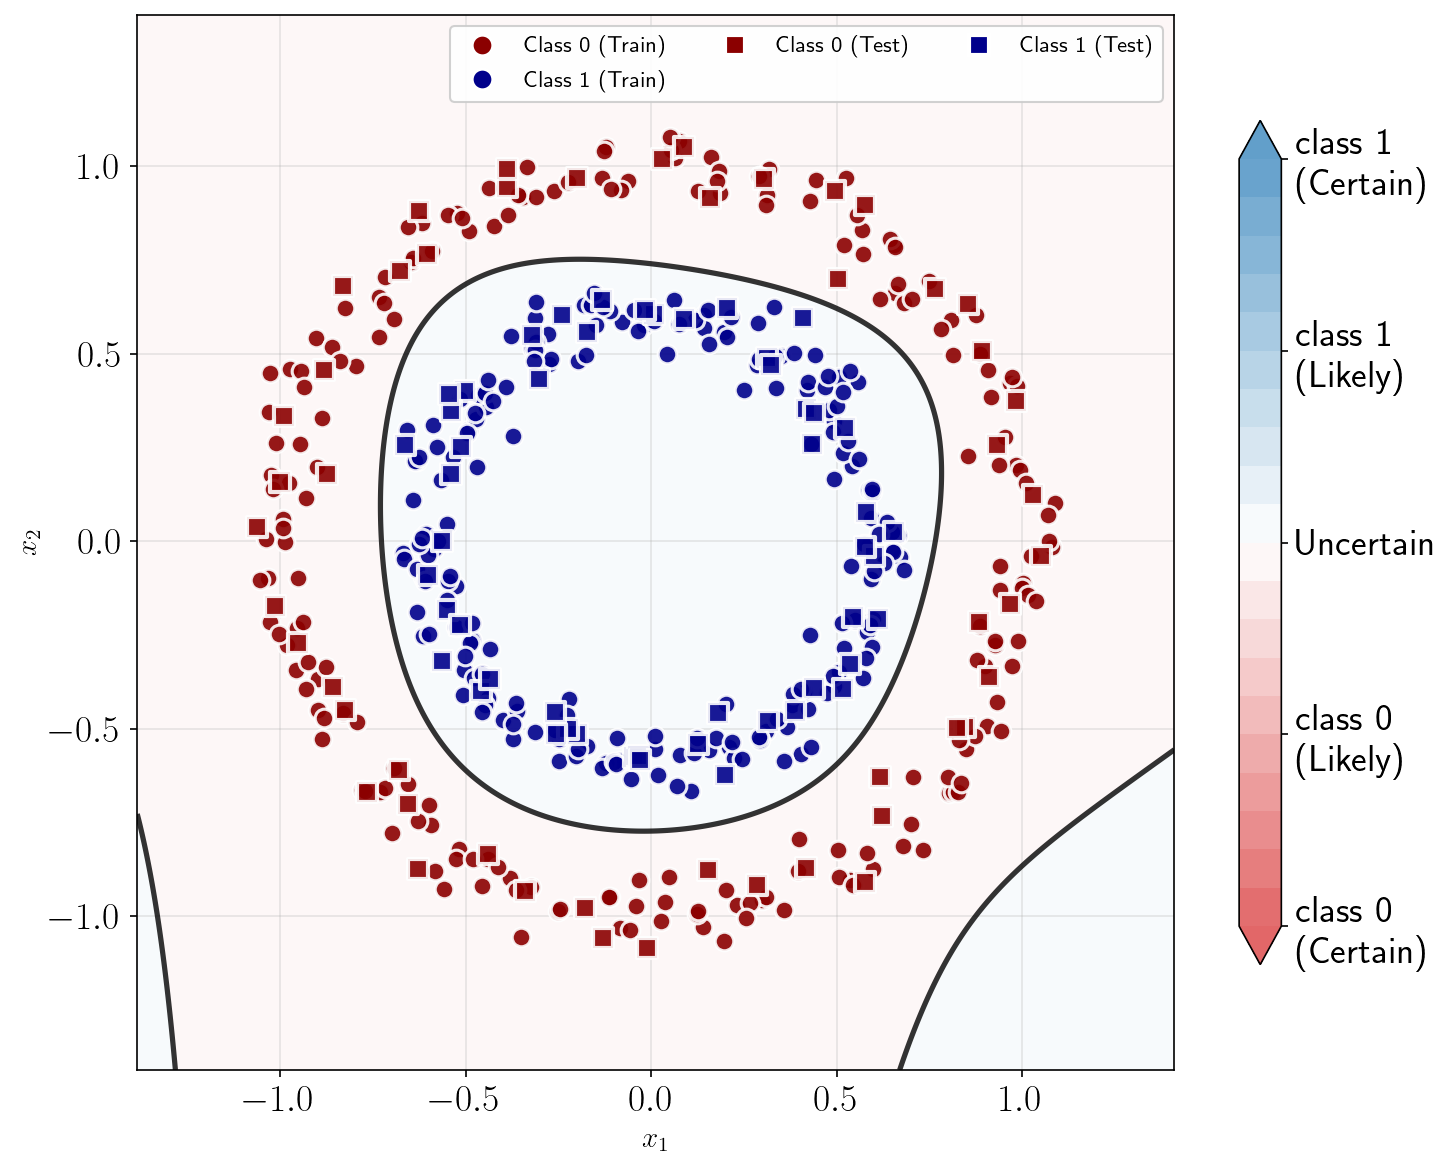

In [11]:
import numpy as np
from reuploading_experiment import MerlinReuploadingClassifier
from utils import plot_training_loss, plot_probability_axis, plot_classification_map

# ---------------------------------------------------
# -------------------- PLAY WITH --------------------
num_layers = 4

dataset = circles_dataset   # Alternative: moons_dataset
X_train, y_train = dataset.train
X_test,  y_test  = dataset.test

max_epochs = 10_000         # Fixed in the paper
patience = 1_000            # Convergence
learning_rate = 1e-3        # Fixed in the paper
batch_size = len(X_train)   # Stabilization in the convergence at the cost of longer training time

alpha = np.pi/10
tau = 1.0
# ---------------------------------------------------


model = MerlinReuploadingClassifier(
    dimension=X_train.shape[1],
    num_layers=num_layers,
    design = "AA",
    alpha = alpha
)

model.fit(
    X_train, y_train,
    track_history=True,
    max_epochs=max_epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    patience=patience,
    tau=tau
)

train_acc = model.score(X_train, y_train)
print("     Train:", train_acc)
test_acc = model.score(X_test, y_test)
print("     Test :",test_acc)
acc = (len(y_train)*train_acc + len(y_test)*test_acc)/(len(y_train)+len(y_test))

plot_training_loss(model)
plot_probability_axis(model, X_train, y_train, offset=0.05)
plot_classification_map(model, X_train, y_train, X_test, y_test, resolution=500)

In order to better understand the impact of the circuit architecture and the hyperparameters, run the python codes:

In [ ]:
! python architecture_grid_run.py  

In [ ]:
! python tau_alpha_grid_run.py

### Perceval Training - Example

In [1]:
from paper_datasets import CirclesDataset
circles_dataset = CirclesDataset(n_train=400, n_test=100)

from paper_datasets import MoonsDataset
moons_dataset = MoonsDataset(n_train=400, n_test=100)

COBYLA
<br>
<br>
Builds a local linear approximation of the loss $\mathcal{L}(p(\overrightarrow{\phi}); X, y)$ using $2 n_{layers} + 1$  points (since $\text{dim}\phi=2 n_{layers}$).

<p align="center">
  <img src="https://www.researchgate.net/publication/392531481/figure/fig2/AS:11431281491427207@1749535451749/The-schematic-diagram-of-COBYLA-in-a-two-dimensional-variable-space-The-smaller-value.jpg" alt="Ansatz Extension" style="width: 50%; height: auto;">
</p>

Parameters:
- $x_0$: initial guess for all parameters.
- $\rho_{begin}$ (often `rhobeg`): the maximum step length the algorithm can try at the beginning.
- $\rho_{end}$ (often `rhoend`): $\rho \le \rho_{end}$ stopping condition. Ideally set to phase-shifter precision.
- `max_iter`: safety cap on work.

Algorithm:
1. Fit a linear model of the loss $f_\mathcal{L}(x)$ from the current $p+1$ points (an affine plane that interpolates those values).
2. Pick a step $d$ that along the negative slope of the linear model truncated to length at most $\rho$.  
3. Evaluate the true $f(x+d)$, update the point set and $\rho$.
5. Stop when $\rho \le \rho_{end}$ or `max_iter` is reached.

Note: In the very first step, COBYLA forms a simplex around $x_0$ using deterministic offsets like $x_0 + \rho_{begin} \cdot \overrightarrow{e_i}$ (unit vectors).  
Note: The update rule for $\rho$ is,
- If the new point improves the loss about as the linear model predicted, keep $\rho$ as it is.
- If there’s little/no improvement (or model looks unreliable), shrink:  
  $\rho \leftarrow \max(\rho_{end}, 1/2 · \rho)$

<div align="center"><u>Side note on the shot budget on training</u></div>

When executing variational quantum ML on a real QPU, the number of shots is a hard budget you must manage carefully. Shots are the main driver of both cost and statistical accuracy. 
<br>
<br>
In particular, the loss is, 

\begin{equation*}
\hat{\mathcal{L}}(\vec\phi; X, y)=\mathcal{L}\left(\big[\hat{p}_{\vec\phi}(x^{(i)})\big]_{i=1}^{n_{\text{train}}},\, \big[y^{(i)}\big]_{i=1}^{n_{\text{train}}}\right),
\end{equation*}

where $\big[\hat{p}_{\vec\phi}(x^{(i)})\big]$ corresponds to the probability of measuring the photon in the top mode for the circuit with variational parameters $\vec\phi$.
On hardware, each $\hat{p}_{\vec\phi}(x^{(i)})$ is estimated from $n_{\text{shots}}$ repeated shots.
The more shots, the smaller the variance: $\sigma \propto p(1-p)/\sqrt{n_{\text{shots}}} $.  

 
Reducing the batch size from $n_{\text{train}}$ to $n_{\text{batch}}$ or the number of shots per estimate $\hat{p}(x^{(i)})$ could decrease significatively the number of shots at the cost of increasing the variance for the loss. This increase of the variance could yield to an increased number iterations possibly increasing the total number of shots:
\begin{equation*}
\boxed{ \; N_{\text{shots, total}} \;\le\; N_{\text{iter}} \,\cdot\, n_{\text{train}} \,\cdot\, n_{\text{shots}} \; }.
\end{equation*}

nelder-mead

In [2]:
import numpy as np
from perceval import NoiseModel
from reuploading_experiment import PercevalReuploadingClassifier
from utils import plot_training_loss, plot_probability_axis, plot_classification_map

# ---------------------------------------------------
# -------------------- PLAY WITH --------------------
num_layers = 4 

dataset = circles_dataset   # Alternative: moons_dataset
X_train, y_train = dataset.train
X_test,  y_test  = dataset.test

alpha = np.pi/10
tau = 1.0

optimizer = "cobyla"
n_shots_training = 1_000
n_shots_inference = 1_000

max_epochs = 1_000_000          # 10x smaller than in the paper (reduce training time)
# Cobyla Parameters
tol = 1e-6                  # Tolerance for convergence in COBYLA optimizer
rhobeg =  np.pi/2
# Adam Parameters
batch_size = len(X_train)   # Stabilization in the convergence at the cost of longer training time
learning_rate = 1e-3

noise_model = None
# noise_model = NoiseModel(
#     phase_imprecision=None,  # e.g. you allow at most ±0.0001 rad systematic rounding
#     phase_error=None          # Gaussian random noise width ±0.001 rad
# )
# ---------------------------------------------------

model = PercevalReuploadingClassifier(
    dimension=X_train.shape[1],
    num_layers=num_layers,
    design = "AA",
    alpha = alpha,
    noise_model=noise_model  # No noise model used in the paper
)

model.fit(
    X_train, y_train,
    optimizer=optimizer,
    track_history=True,
    max_epochs=max_epochs,
    lr=learning_rate,
    psr_batch_size=batch_size,
    tau=tau,
    n_shots=n_shots_training
)

train_acc = model.score(X_train, y_train, n_shots=n_shots_inference)
print("     Train:", train_acc)
test_acc = model.score(X_test, y_test, n_shots=n_shots_inference)
print("     Test :",test_acc)
acc = (len(y_train)*train_acc + len(y_test)*test_acc)/(len(y_train)+len(y_test))

plot_training_loss(model)
# plot_probability_axis(model, X_train, y_train, offset=0.05)
# plot_classification_map(model, X_train, y_train, X_test, y_test, resolution=50, n_shots=n_shots_inference)


Return from COBYLA because the trust region radius reaches its lower bound.
Number of function values = 100   Least value of F = 1.1253765865877874
The corresponding X is:
[1.72457695 2.64873041 1.47872669 1.43542172 0.85348074 1.72107459
 3.64603575 6.4743891 ]

     Train: 0.7275
     Test : 0.74


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss17.tfm' in your texmf tree, but could not find it

Error in callback <function _draw_all_if_interactive at 0x00000229D63E6E80> (for post_execute), with arguments args (),kwargs {}:


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss17.tfm' in your texmf tree, but could not find it

FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss17.tfm' in your texmf tree, but could not find it

<Figure size 1000x600 with 1 Axes>

## Noiseless reproduction of [Figure 5](https://arxiv.org/html/2507.05120v1/x3.png) using Merlin

In [25]:
import seaborn as sns
import pandas as pd

def plot_figure_5(all_train_accuracies, all_test_accuracies, range_num_layers, COLORS=None):
    """
    Plot the training and test accuracy as a function of the number of layers using box plots.

    Parameters:
    - all_train_accuracies: list of lists, each sublist contains multiple train accuracies for a layer
    - all_test_accuracies: list of lists, each sublist contains multiple test accuracies for a layer
    - range_num_layers: list of layer counts (e.g., [1, 2, 3, 4, 5])
    - COLORS: optional list of two colors for 'Train' and 'Test'
    """
    # Prepare the dataframe
    data = []
    for i, num_layers in enumerate(range_num_layers):
        for acc in all_train_accuracies[i]:
            data.append({'Layers': num_layers, 'Accuracy': acc, 'Type': 'Train'})
        for acc in all_test_accuracies[i]:
            data.append({'Layers': num_layers, 'Accuracy': acc, 'Type': 'Test'})
    df = pd.DataFrame(data)

    # Default colors if none provided
    if COLORS is None:
        COLORS = ['#1f77b4', '#ff7f0e']  # Blue for train, orange for test

    # Plot using boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Layers', y='Accuracy', hue='Type', palette=COLORS)
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$\mathcal{A}$')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Circles

In [ ]:
alpha = np.pi/10
tau = 1.0

range_num_layers = range(1,16)
rep = 5

all_train_accuracies_circles = []
all_test_accuracies_circles = []

for num_layers in range_num_layers:
    train_accuracies = []
    test_accuracies = []
    for _ in range(rep):
        circles_dataset = CirclesDataset(n_train=400, n_test=100)
        X_train, y_train = circles_dataset.train
        X_test, y_test = circles_dataset.test

        model = MerlinReuploadingClassifier(
            dimension=X_train.shape[1],
            num_layers=num_layers,
            design = "AA",
            alpha = alpha
        )

        model.fit(
            X_train, y_train,
            track_history=True,
            max_epochs=max_epochs,
            learning_rate=learning_rate,
            batch_size=batch_size,
            patience=patience,
            tau=tau
        )
        train_accuracies.append(model.score(X_train, y_train))
        test_accuracies.append(model.score(X_test, y_test))

    all_train_accuracies_circles.append(train_accuracies)
    all_test_accuracies_circles.append(test_accuracies)

# [[0.7275, 0.7375, 0.7275, 0.7225, 0.725], [0.815, 0.8125, 0.8325, 0.825, 0.8125], [0.925, 1.0, 0.945, 0.9375, 1.0], [1.0, 1.0, 1.0, 1.0, 0.995], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0]]
# [[0.71, 0.71, 0.73, 0.74, 0.73], [0.84, 0.85, 0.83, 0.79, 0.81], [0.95, 1.0, 0.94, 0.93, 1.0], [1.0, 1.0, 1.0, 1.0, 0.98], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.99], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0]]

[[0.7275, 0.7375, 0.7275, 0.7225, 0.725], [0.815, 0.8125, 0.8325, 0.825, 0.8125], [0.925, 1.0, 0.945, 0.9375, 1.0], [1.0, 1.0, 1.0, 1.0, 0.995], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0]]
[[0.71, 0.71, 0.73, 0.74, 0.73], [0.84, 0.85, 0.83, 0.79, 0.81], [0.95, 1.0, 0.94, 0.93, 1.0], [1.0, 1.0, 1.0, 1.0, 0.98], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.99], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0]]


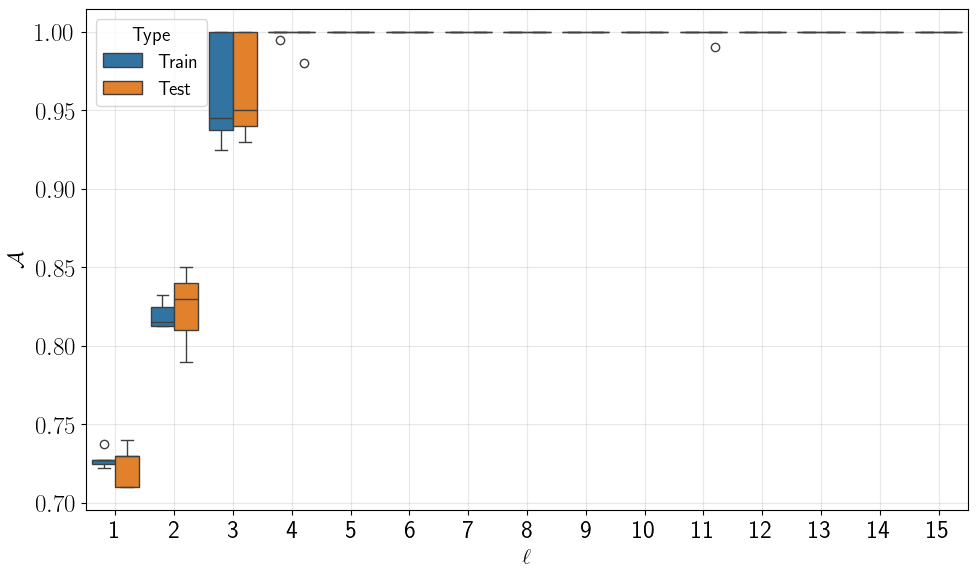

In [26]:
print(all_train_accuracies_circles)
print(all_test_accuracies_circles)

plot_figure_5(all_train_accuracies_circles, all_test_accuracies_circles, range_num_layers)

### Moons

In [ ]:
alpha = np.pi/10
tau = 1.0

range_num_layers = range(1,16)
rep = 5

all_train_accuracies_moons = []
all_test_accuracies_moons = []

for num_layers in range_num_layers:
    train_accuracies = []
    test_accuracies = []
    for _ in range(rep):
        moons_dataset = MoonsDataset(n_train=400, n_test=100)
        X_train, y_train = moons_dataset.train
        X_test, y_test = moons_dataset.test

        model = MerlinReuploadingClassifier(
            dimension=X_train.shape[1],
            num_layers=num_layers,
            design = "AA",
            alpha = alpha
        )

        model.fit(
            X_train, y_train,
            track_history=True,
            max_epochs=max_epochs,
            learning_rate=learning_rate,
            batch_size=batch_size,
            patience=patience,
            tau=tau
        )
        
        train_accuracies.append(model.score(X_train, y_train))
        test_accuracies.append(model.score(X_test, y_test))

    all_train_accuracies_moons.append(train_accuracies)
    all_test_accuracies_moons.append(test_accuracies)

# [[0.835, 0.8425, 0.83, 0.835, 0.845], [0.875, 0.8675, 0.88, 0.88, 0.87], [0.95, 0.9875, 0.9525, 0.945, 0.9525], [0.9975, 0.9925, 0.9975, 0.9825, 0.995], [1.0, 0.9975, 0.99, 0.9875, 1.0], [1.0, 1.0, 0.9975, 1.0, 0.995], [0.9975, 1.0, 1.0, 0.9975, 0.9975], [1.0, 1.0, 1.0, 0.9975, 1.0], [1.0, 0.9975, 1.0, 1.0, 0.9975], [1.0, 0.9925, 1.0, 1.0, 1.0], [0.9975, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.995, 1.0, 1.0], [1.0, 0.9975, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0]]
# [[0.86, 0.8, 0.8, 0.84, 0.82], [0.87, 0.87, 0.89, 0.86, 0.85], [0.95, 0.97, 0.95, 0.96, 0.94], [0.99, 1.0, 1.0, 0.98, 1.0], [0.99, 0.99, 0.97, 0.97, 0.99], [1.0, 1.0, 0.99, 1.0, 1.0], [1.0, 1.0, 1.0, 0.99, 0.99], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.99, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.99, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.99, 1.0, 0.99, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0]]

[[0.835, 0.8425, 0.83, 0.835, 0.845], [0.875, 0.8675, 0.88, 0.88, 0.87], [0.95, 0.9875, 0.9525, 0.945, 0.9525], [0.9975, 0.9925, 0.9975, 0.9825, 0.995], [1.0, 0.9975, 0.99, 0.9875, 1.0], [1.0, 1.0, 0.9975, 1.0, 0.995], [0.9975, 1.0, 1.0, 0.9975, 0.9975], [1.0, 1.0, 1.0, 0.9975, 1.0], [1.0, 0.9975, 1.0, 1.0, 0.9975], [1.0, 0.9925, 1.0, 1.0, 1.0], [0.9975, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.995, 1.0, 1.0], [1.0, 0.9975, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0]]
[[0.86, 0.8, 0.8, 0.84, 0.82], [0.87, 0.87, 0.89, 0.86, 0.85], [0.95, 0.97, 0.95, 0.96, 0.94], [0.99, 1.0, 1.0, 0.98, 1.0], [0.99, 0.99, 0.97, 0.97, 0.99], [1.0, 1.0, 0.99, 1.0, 1.0], [1.0, 1.0, 1.0, 0.99, 0.99], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.99, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.99, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.99, 1.0, 0.99, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0]]


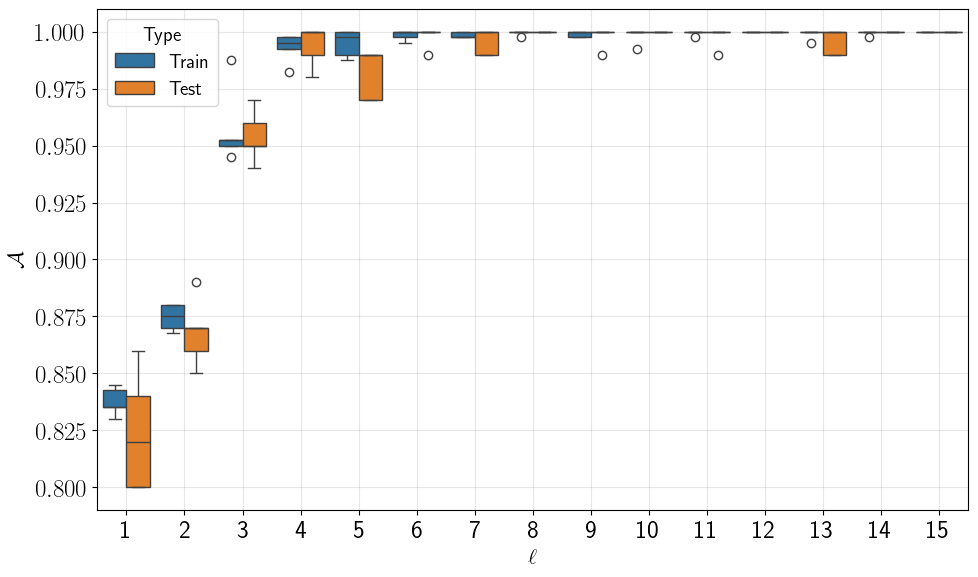

In [27]:
print(all_train_accuracies_moons)
print(all_test_accuracies_moons)

plot_figure_5(all_train_accuracies_moons, all_test_accuracies_moons, range_num_layers)

### Tetromino

In [ ]:
from paper_datasets import TetrominoDataset

range_num_layers = range(1,16)
rep = 5

all_train_accuracies_tetromino = []
all_test_accuracies_tetromino = []

for num_layers in range_num_layers:
    train_accuracies = []
    test_accuracies = []
    for _ in range(rep):
        tetromino_dataset = TetrominoDataset(n_train=400, n_test=100)
        X_train, y_train = tetromino_dataset.train
        X_test, y_test = tetromino_dataset.test

        model = MerlinReuploadingClassifier(
            dimension=X_train.shape[1],
            num_layers=num_layers,
            design = "AA",
            alpha = alpha
        )

        model.fit(
            X_train, y_train,
            track_history=True,
            max_epochs=max_epochs,
            learning_rate=learning_rate,
            batch_size=batch_size,
            patience=patience,
            tau=tau
        )
        
        train_accuracies.append(model.score(X_train, y_train))
        test_accuracies.append(model.score(X_test, y_test))

    all_train_accuracies_tetromino.append(train_accuracies)
    all_test_accuracies_tetromino.append(test_accuracies)

# [[0.7975, 0.8975, 0.9475, 0.965, 0.8025], [0.9975, 0.9875, 0.995, 0.99, 1.0], [1.0, 1.0, 0.9975, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0]]
# [[0.69, 0.9, 0.91, 0.98, 0.85], [1.0, 0.99, 0.99, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0]]

[[0.7975, 0.8975, 0.9475, 0.965, 0.8025], [0.9975, 0.9875, 0.995, 0.99, 1.0], [1.0, 1.0, 0.9975, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0]]
[[0.69, 0.9, 0.91, 0.98, 0.85], [1.0, 0.99, 0.99, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0]]


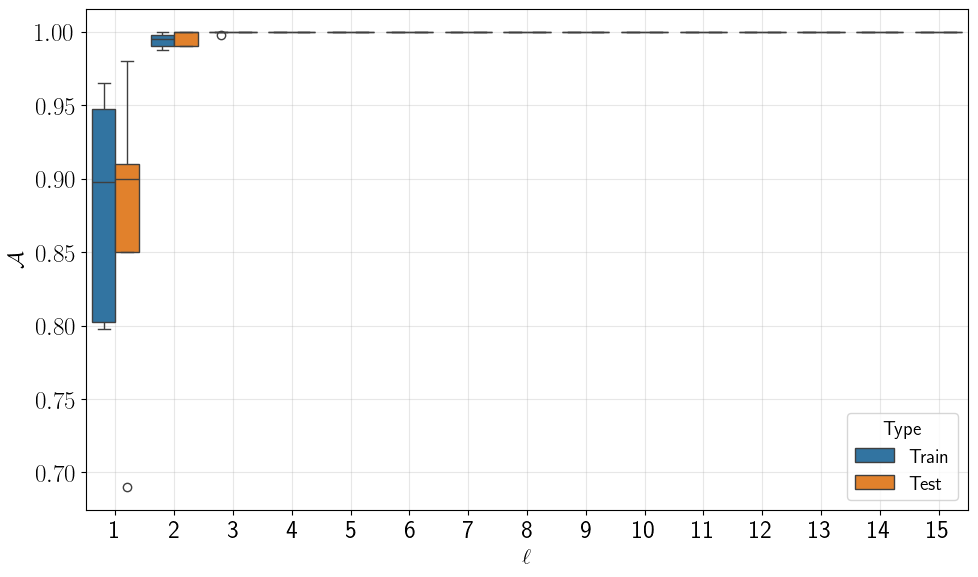

In [ ]:
print(all_train_accuracies_tetromino)
print(all_test_accuracies_tetromino)

plot_figure_5(all_train_accuracies_tetromino, all_test_accuracies_tetromino, range_num_layers)

### OverheadMNIST

In [18]:
from paper_datasets import OverheadMNISTDataset
from reuploading_experiment import MerlinReuploadingClassifier
rep = 5
num_layers = 4

train_accuracies_overhead = []
test_accuracies_overhead = []
for _ in range(rep):
    overhead_dataset = OverheadMNISTDataset(n_train=200, n_test=50, balanced=True, root="overheadmnist")
    X_train, y_train = overhead_dataset.train
    X_test, y_test = overhead_dataset.test

    model = MerlinReuploadingClassifier(
        dimension=X_train.shape[1],
        num_layers=num_layers,
        design = "AA",
        alpha = alpha
    )

    model.fit(
        X_train, y_train,
        track_history=True,
        max_epochs=max_epochs,
        learning_rate=learning_rate,
        batch_size=batch_size,
        patience=patience,
        tau=tau
    )
    train_accuracies_overhead.append(model.score(X_train, y_train))
    test_accuracies_overhead.append(model.score(X_test, y_test))

In [ ]:
print(train_accuracies_overhead)
print(test_accuracies_overhead)

plot_figure_5([train_accuracies_overhead], [train_accuracies_overhead], [num_layers])

NameError: name 'plot_figure_5' is not defined

## References

- Dorfer, M., Kelz, R., & Widmer, G. (2016). Deep Linear Discriminant Analysis. *ICLR 2016 (workshop)*. [arXiv:1511.04707](https://arxiv.org/abs/1511.04707)
- Kreplin, D. A., & Roth, M. (2024). Reduction of finite sampling noise in quantum neural networks. *Quantum*. [arXiv:2306.01639](https://arxiv.org/abs/2306.01639)
